In [1]:
import pandas as pd
import matplotlib.pyplot as plt
# import sklearn, catboost, xgboost

# from lightgbm import LGBMClassifier
# from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import RidgeClassifier
from sklearn.metrics import classification_report
# from sklearn.metrics import ConfusionMatrixDisplay
# from sklearn.metrics import classification_report, plot_confusion_matrix
# from sklearn.metrics import plot_precision_recall_curve, plot_roc_curve, precision_recall_curve, average_precision_score, roc_curve, auc

from sklearn.preprocessing import StandardScaler

In [2]:
# Predict your new samples of silica nanoparticles by running this code, and PLEASE WAIT until the results have been downloaded

your_new_samples_id = 150
independent_id = 116
data = pd.read_csv(r'./Main_Indepedent_Dataset.csv', encoding='unicode_escape')

def convert(Cell_viability):
    if Cell_viability == 'Cytotoxic':
        return 1
    if Cell_viability == 'Non_cytotoxic':
        return 0
    else:
        return ''

def convert_back(Cell_viability):
    if Cell_viability == 1:
        return 'Cytotoxic'
    if Cell_viability == 0:
        return 'Non_cytotoxic'
    else:
      return ''

data['convert'] = data['Cell_viability'].apply(convert)
data = data.drop('Cell_viability', axis=1)
data = data.rename(columns={'convert':'Cell_viability'})

shuffled_main_dataset = data[data['Publication_id'] < independent_id].sample(frac=1, random_state=2022)
independent_dataset = data[data['Publication_id'] >= independent_id]
data = pd.concat([shuffled_main_dataset, independent_dataset])

X = data.drop(columns=['Viability_indicator','Cell_viability','Positive_control', 'Positive_control_inducer','SiO$_{2}$NP_label', 'Interference_testing','Viability_mechanism','Assay_viability'], axis=1)
# X = X.drop([
#     'SiO$_{2}$NP_medium_serum_15%_FBS',
#     'Cell_morphology_microglia',

#     'Cell_organ_heart',

#     'Cell_id_MPMC/3t3',

#     'Surface_modification_CHO',
#     'Hydrodynamic_size_water_nm_not_determined',
#     'Cell_source_hamster',
#     'Assay_viability_Sytox_Red',

#     'Viability_indicator_live_cell',
# ], axis=1)

y = data[['Cell_viability', 'Publication_id']]
y = y[y['Publication_id'] < independent_id]
y = y.drop('Publication_id',axis=1)
# y = y.to_numpy().ravel()

y_test = data[['Cell_viability','Publication_id']]
y_test = y_test[y_test['Publication_id'] >= independent_id]
y_test =  y_test.drop('Publication_id',axis=1)
y_test = y_test.values

X_test = X[X['Publication_id'] >= independent_id]
X_test = X_test.drop('Publication_id',axis=1)
X_test = X_test.sort_index(ascending=True)
X_test_shap = X_test
X_test = X_test.values.reshape(-1,len(X_test.columns))

X = X[X['Publication_id'] < independent_id]
X = X.drop('Publication_id',axis=1)


In [3]:
X.columns

Index(['Concentration_µg/ml', 'SiO$_{2}$NP_medium_serum', 'Cell_morphology',
       'Cell_organ', 'Primary_size_nm', 'Cell_id', 'Exposure_time_h',
       'Surface_modification', 'Hydrodynamic_size_water_nm', 'Cell_source',
       'Surface_area_m2/g', 'Primary_size_verification', 'Exposure_medium',
       'Zeta_potential_water_mV', 'Hydrodynamic_size_culture_nm',
       'SiO$_{2}$NP_synthesis', 'Hydrodynamic_size_serum_nm', 'PDI_water',
       'Cell_disease', 'SiO$_{2}$NP_source', 'Cell_culture',
       'Zeta_potential_PBS/HBSS_mV', 'Surface_charge_culture',
       'Zeta_potential_serum_mV', 'Zeta_potential_culture_mV', 'Cell_age',
       'PDI_culture', 'Surface_charge_water', 'SiO$_{2}$NP_shape'],
      dtype='object')

In [4]:
feature_names = X.columns.tolist()
print(f"Original Feature Names: {feature_names}")

Original Feature Names: ['Concentration_µg/ml', 'SiO$_{2}$NP_medium_serum', 'Cell_morphology', 'Cell_organ', 'Primary_size_nm', 'Cell_id', 'Exposure_time_h', 'Surface_modification', 'Hydrodynamic_size_water_nm', 'Cell_source', 'Surface_area_m2/g', 'Primary_size_verification', 'Exposure_medium', 'Zeta_potential_water_mV', 'Hydrodynamic_size_culture_nm', 'SiO$_{2}$NP_synthesis', 'Hydrodynamic_size_serum_nm', 'PDI_water', 'Cell_disease', 'SiO$_{2}$NP_source', 'Cell_culture', 'Zeta_potential_PBS/HBSS_mV', 'Surface_charge_culture', 'Zeta_potential_serum_mV', 'Zeta_potential_culture_mV', 'Cell_age', 'PDI_culture', 'Surface_charge_water', 'SiO$_{2}$NP_shape']


In [5]:
from tabpfn_extensions import interpretability

/root/miniconda3/lib/python3.10/site-packages/hyperopt/atpe.py:19: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


In [6]:
X

,Concentration_µg/ml,SiO$_{2}$NP_medium_serum,Cell_morphology,Cell_organ,Primary_size_nm,Cell_id,Exposure_time_h,Surface_modification,Hydrodynamic_size_water_nm,Cell_source,...,SiO$_{2}$NP_source,Cell_culture,Zeta_potential_PBS/HBSS_mV,Surface_charge_culture,Zeta_potential_serum_mV,Zeta_potential_culture_mV,Cell_age,PDI_culture,Surface_charge_water,SiO$_{2}$NP_shape
3828,50.0,serum_free,epithelial,liver,59.72,HepG2,72.0,unmodified,51-75,human,...,in_house,cell_line,not_determined,not_determined,not_determined,not_determined,non_embryonic,not_determined,negative,sphere
189,167.0,serum_free,fibroblast,skin,15.20,CCD-966sk,48.0,chitosan,not_determined,human,...,in_house,cell_line,not_determined,not_determined,not_determined,not_determined,non_embryonic,not_determined,negative,sphere
644,90.0,serum_free,endothelial,cell_hybrid,19.40,EAHY926,24.0,unmodified,less_26,human,...,in_house,cell_line,not_determined,not_determined,not_determined,not_determined,non_embryonic,not_determined,negative,sphere
3655,40.0,10%_FBS,epithelial,lung,13.00,16HBE,24.0,unmodified,151-200,human,...,in_house,cell_line,not_determined,not_determined,negative_11-20,not_determined,non_embryonic,not_determined,negative,sphere
604,10.0,serum_free,endothelial,cell_hybrid,13.80,EAHY926,24.0,unmodified,less_26,human,...,commercial,cell_line,not_determined,negative,not_determined,negative_1-10,non_embryonic,not_determined,negative,sphere
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2849,300.0,serum_free,epithelial,lung,11.70,H441,4.0,unmodified,less_26,human,...,commercial,cell_line,not_determined,not_determined,not_determined,not_determined,non_embryonic,0.101-0.2,negative,sphere
24,100.0,10%_FBS,monocyte_macrophage,blood,100.00,Mono_Mac_6,24.0,unmodified,not_determined,human,...,in_house,cell_line,not_determined,not_determined,not_determined,not_determined,non_embryonic,not_determined,negative,sphere
2066,100.0,serum_free,epithelial,kidney,85.69,LLC-PK1,72.0,unmodified,not_determined,pig,...,in_house,cell_line,not_determined,not_determined,not_determined,not_determined,non_embryonic,not_determined,negative,sphere
173,667.0,serum_free,epithelial,lung,80.21,A549,48.0,unmodified,not_determined,human,...,in_house,cell_line,not_determined,not_determined,not_determined,not_determined,non_embryonic,not_determined,negative,sphere


In [7]:
df_numeric_bool = X.select_dtypes(include=['object'])
df_numeric_bool

,SiO$_{2}$NP_medium_serum,Cell_morphology,Cell_organ,Cell_id,Surface_modification,Hydrodynamic_size_water_nm,Cell_source,Primary_size_verification,Exposure_medium,Zeta_potential_water_mV,...,SiO$_{2}$NP_source,Cell_culture,Zeta_potential_PBS/HBSS_mV,Surface_charge_culture,Zeta_potential_serum_mV,Zeta_potential_culture_mV,Cell_age,PDI_culture,Surface_charge_water,SiO$_{2}$NP_shape
3828,serum_free,epithelial,liver,HepG2,unmodified,51-75,human,verified,DMEM,negative_31-40,...,in_house,cell_line,not_determined,not_determined,not_determined,not_determined,non_embryonic,not_determined,negative,sphere
189,serum_free,fibroblast,skin,CCD-966sk,chitosan,not_determined,human,verified,DMEM,not_determined,...,in_house,cell_line,not_determined,not_determined,not_determined,not_determined,non_embryonic,not_determined,negative,sphere
644,serum_free,endothelial,cell_hybrid,EAHY926,unmodified,less_26,human,verified,DMEM,not_determined,...,in_house,cell_line,not_determined,not_determined,not_determined,not_determined,non_embryonic,not_determined,negative,sphere
3655,10%_FBS,epithelial,lung,16HBE,unmodified,151-200,human,verified,RPMI_1640,negative_41-50,...,in_house,cell_line,not_determined,not_determined,negative_11-20,not_determined,non_embryonic,not_determined,negative,sphere
604,serum_free,endothelial,cell_hybrid,EAHY926,unmodified,less_26,human,verified,DMEM,negative_21-30,...,commercial,cell_line,not_determined,negative,not_determined,negative_1-10,non_embryonic,not_determined,negative,sphere
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2849,serum_free,epithelial,lung,H441,unmodified,less_26,human,verified,RPMI_1640,not_determined,...,commercial,cell_line,not_determined,not_determined,not_determined,not_determined,non_embryonic,0.101-0.2,negative,sphere
24,10%_FBS,monocyte_macrophage,blood,Mono_Mac_6,unmodified,not_determined,human,verified,DMEM,not_determined,...,in_house,cell_line,not_determined,not_determined,not_determined,not_determined,non_embryonic,not_determined,negative,sphere
2066,serum_free,epithelial,kidney,LLC-PK1,unmodified,not_determined,pig,verified,RPMI_1640,negative_51-60,...,in_house,cell_line,not_determined,not_determined,not_determined,not_determined,non_embryonic,not_determined,negative,sphere
173,serum_free,epithelial,lung,A549,unmodified,not_determined,human,verified,DMEM,not_determined,...,in_house,cell_line,not_determined,not_determined,not_determined,not_determined,non_embryonic,not_determined,negative,sphere


In [8]:
# np.isfinite(df_numeric_bool).all()


# for i in np.isfinite(df_numeric_bool).all():
#     print(i)

In [9]:
# print(df_numeric_bool.dtypes)

In [10]:
# import shap
# explainer = shap.Explainer(clf)
# explainer.expected_value = explainer.expected_value[0]
# shap_values = explainer(X_test_shap)

In [11]:
# df_shap = df_numeric_bool.copy()
# for col in df_shap.columns:
#     if pd.api.types.is_bool_dtype(df_shap[col]):
#         df_shap[col] = df_shap[col].astype(float)

In [12]:
# df_shap

In [13]:
# df_shap.columns

In [14]:
# df_shap_float = df_shap.copy()
# for col in df_shap_float.columns:
#     if pd.api.types.is_bool_dtype(df_shap_float[col]):
#         df_shap_float[col] = df_shap_float[col].astype(float)

In [15]:
# df_shap_float.columns

In [16]:
n_samples = 50

In [17]:
# df_numeric_bool

In [18]:
# X_test

In [19]:
from typing import Any, Callable
import torch

In [20]:
import numpy as np

In [21]:
def get_shap_values(
    estimator: Any,
    test_x: pd.DataFrame | np.ndarray | torch.Tensor,
    attribute_names: list[str] | None = None,
    **kwargs: Any,
) -> np.ndarray:
    """Compute SHAP values for a model's predictions on input features.

    This function calculates SHAP (SHapley Additive exPlanations) values that
    attribute the contribution of each input feature to the model's output.
    It automatically selects the appropriate SHAP explainer based on the model.

    Args:
        estimator: The model to explain, typically a TabPFNClassifier or scikit-learn compatible model.
        test_x: The input features to compute SHAP values for.
        attribute_names: Column names for the features when test_x is a numpy array.
        **kwargs: Additional keyword arguments to pass to the SHAP explainer.

    Returns:
        np.ndarray: The computed SHAP values with shape (n_samples, n_features).
    """
    if isinstance(test_x, torch.Tensor):
        test_x = test_x.cpu().numpy()

    if isinstance(test_x, np.ndarray):
        test_x = pd.DataFrame(test_x)
        if attribute_names is not None:
            test_x.columns = attribute_names
        else:
            test_x = test_x.rename(columns={c: str(c) for c in test_x.columns})

    if hasattr(estimator, "predict_function_for_shap"):
        predict_function_for_shap = estimator.predict_function_for_shap
    else:
        predict_function_for_shap = (
            "predict_proba" if hasattr(estimator, "predict_proba") else "predict"
        )

    if hasattr(estimator, "fit_at_predict_time"):
        if not estimator.fit_at_predict_time:
            pass

    def get_shap() -> np.ndarray:
        if is_tabpfn(estimator):
            explainer = get_tabpfn_explainer(
                estimator,
                test_x,
                predict_function_for_shap,
                **kwargs,
            )
        else:
            explainer = get_default_explainer(
                estimator,
                test_x,
                predict_function_for_shap,
                **kwargs,
            )
        return explainer(test_x)

    if hasattr(estimator, "show_progress"):
        show_progress_ = estimator.show_progress
        estimator.show_progress = False
        try:
            shap_values = get_shap()
        finally:
            estimator.show_progress = show_progress_
    else:
        shap_values = get_shap()

    return shap_values

In [22]:
from tabpfn_extensions.utils import is_tabpfn

In [23]:
def get_tabpfn_explainer(
    estimator: Any,
    test_x: pd.DataFrame,
    predict_function_for_shap: str | Callable = "predict",
    feature_names=list,
    **kwargs: Any,
) -> Any:
    """Create a SHAP explainer specifically optimized for TabPFN models.

    Args:
        estimator: The TabPFN model to explain.
        test_x: The input features to compute SHAP values for.
        predict_function_for_shap: Function name or callable to use for prediction.
            Defaults to "predict".
        **kwargs: Additional keyword arguments to pass to the SHAP explainer.

    Returns:
        Any: A configured SHAP explainer for the TabPFN model.
    """
    import shap
    print(test_x,predict_function_for_shap)
    return shap.Explainer(
        getattr(estimator, predict_function_for_shap)
        if isinstance(predict_function_for_shap, str)
        else predict_function_for_shap,
        np.ones(test_x.iloc[0:1, :].shape,dtype=float) * float("nan"),
        feature_names=feature_names
        **kwargs,
    )

In [24]:
# -----------------------------
# 完整示例：TabPFN + SHAP
# -----------------------------
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from tabpfn import TabPFNClassifier
import shap
import matplotlib.pyplot as plt

# -----------------------------
# 1. 模拟数据
# -----------------------------
# data = pd.DataFrame({
#     "Concentration_µg/ml": [100.0, 6.25, 10.0, 150.0, 40.0],
#     "SiO2_medium_serum": ["serum_free", "10%_FBS", "serum_free", "serum_free", "serum_free"],
#     "Cell_morphology": ["epithelial", "monocyte_macrophage", "endothelial", "endothelial", "monocyte_macrophage"],
#     "Label": [1, 0, 1, 1, 0]
# })

# X = data.drop("Label", axis=1)
# y = data["Label"]

# -----------------------------
# 2. 类别列编码
# -----------------------------
categorical_cols = df_numeric_bool.columns
for col in categorical_cols:
    le = LabelEncoder()
    X[col] = le.fit_transform(X[col])

# -----------------------------
# 3. 转 float
# -----------------------------
X = X.astype(float)

# -----------------------------
# 4. 拆分训练/测试集
# -----------------------------
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)


# -----------------------------
# 4. 训练集拟合、标准化
# -----------------------------
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)  # 只用训练集拟合
X_test_scaled = scaler.transform(X_test)        # 测试集只做 transform

# 如果需要保留 DataFrame 结构和列名
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X.columns, index=X_train.index)
X_test_scaled  = pd.DataFrame(X_test_scaled,  columns=X.columns, index=X_test.index)

# -----------------------------
# 5. 训练 TabPFN
# -----------------------------
clf = TabPFNClassifier()
clf.fit(X_train_scaled.values, y_train)

/root/miniconda3/lib/python3.10/site-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


TabPFNClassifier()

In [25]:
X_train

,Concentration_µg/ml,SiO$_{2}$NP_medium_serum,Cell_morphology,Cell_organ,Primary_size_nm,Cell_id,Exposure_time_h,Surface_modification,Hydrodynamic_size_water_nm,Cell_source,...,SiO$_{2}$NP_source,Cell_culture,Zeta_potential_PBS/HBSS_mV,Surface_charge_culture,Zeta_potential_serum_mV,Zeta_potential_culture_mV,Cell_age,PDI_culture,Surface_charge_water,SiO$_{2}$NP_shape
1277,50.0,5.0,1.0,17.0,495.90,29.0,3.0,10.0,11.0,1.0,...,0.0,1.0,5.0,1.0,7.0,6.0,0.0,6.0,0.0,1.0
3241,200.0,9.0,2.0,13.0,27.50,6.0,20.0,10.0,6.0,1.0,...,0.0,0.0,5.0,1.0,7.0,6.0,1.0,6.0,0.0,1.0
3727,10.0,10.0,2.0,13.0,81.05,4.0,24.0,10.0,11.0,1.0,...,1.0,0.0,5.0,1.0,7.0,6.0,1.0,6.0,0.0,1.0
3056,1000.0,3.0,4.0,15.0,7.00,30.0,24.0,10.0,11.0,1.0,...,0.0,0.0,5.0,1.0,7.0,6.0,1.0,6.0,0.0,1.0
1481,500.0,3.0,2.0,13.0,30.51,4.0,1.0,10.0,10.0,1.0,...,0.0,0.0,5.0,1.0,7.0,6.0,1.0,6.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2277,200.0,3.0,3.0,12.0,15.00,8.0,24.0,10.0,7.0,4.0,...,0.0,0.0,5.0,0.0,7.0,0.0,1.0,6.0,0.0,1.0
2210,12.5,9.0,2.0,13.0,16.00,6.0,24.0,10.0,0.0,1.0,...,1.0,0.0,5.0,0.0,0.0,6.0,1.0,6.0,0.0,1.0
317,667.0,10.0,2.0,13.0,13.30,4.0,48.0,6.0,11.0,1.0,...,1.0,0.0,5.0,1.0,7.0,6.0,1.0,6.0,0.0,1.0
2328,300.0,3.0,6.0,2.0,25.00,34.0,18.0,10.0,10.0,1.0,...,0.0,1.0,0.0,1.0,7.0,6.0,1.0,6.0,0.0,1.0


In [26]:
feature_names

['Concentration_µg/ml',
 'SiO$_{2}$NP_medium_serum',
 'Cell_morphology',
 'Cell_organ',
 'Primary_size_nm',
 'Cell_id',
 'Exposure_time_h',
 'Surface_modification',
 'Hydrodynamic_size_water_nm',
 'Cell_source',
 'Surface_area_m2/g',
 'Primary_size_verification',
 'Exposure_medium',
 'Zeta_potential_water_mV',
 'Hydrodynamic_size_culture_nm',
 'SiO$_{2}$NP_synthesis',
 'Hydrodynamic_size_serum_nm',
 'PDI_water',
 'Cell_disease',
 'SiO$_{2}$NP_source',
 'Cell_culture',
 'Zeta_potential_PBS/HBSS_mV',
 'Surface_charge_culture',
 'Zeta_potential_serum_mV',
 'Zeta_potential_culture_mV',
 'Cell_age',
 'PDI_culture',
 'Surface_charge_water',
 'SiO$_{2}$NP_shape']

In [27]:
# -----------------------------
# 6. 测试准确率
# -----------------------------
predictions = clf.predict(X_test_scaled)
print("Accuracy:", classification_report(y_test, predictions,digits=4))

from sklearn.metrics import classification_report, confusion_matrix


# 混淆矩阵
print("\nConfusion Matrix:\n")
print(confusion_matrix(y_test, predictions))

/root/miniconda3/lib/python3.10/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but TabPFNClassifier was fitted without feature names
  warnings.warn(


Accuracy:               precision    recall  f1-score   support

           0     0.8814    0.9538    0.9162      1060
           1     0.9026    0.7695    0.8307       590

    accuracy                         0.8879      1650
   macro avg     0.8920    0.8616    0.8735      1650
weighted avg     0.8890    0.8879    0.8856      1650


Confusion Matrix:

[[1011   49]
 [ 136  454]]


Classification Report:

               precision    recall  f1-score   support

Non_cytotoxic     0.8814    0.9538    0.9162      1060
    cytotoxic     0.9026    0.7695    0.8307       590

     accuracy                         0.8879      1650
    macro avg     0.8920    0.8616    0.8735      1650
 weighted avg     0.8890    0.8879    0.8856      1650

               Non_cytotoxic  cytotoxic
Non_cytotoxic           1011         49
cytotoxic                136        454


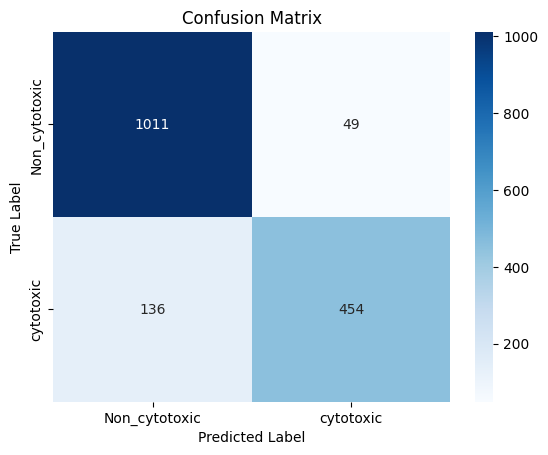

In [28]:
import seaborn as sns
# 指定标签顺序
labels = ["Non_cytotoxic", "cytotoxic"]

# 打印分类报告
print("Classification Report:\n")
print(classification_report(y_test, predictions,
                            target_names=labels,   # 指定类别名
                            digits=4))

# 打印混淆矩阵
cm = confusion_matrix(y_test, predictions)
cm_df = pd.DataFrame(cm,
                     index=[f"{n}" for n in labels],
                     columns=[f"{n}" for n in labels])
print(cm_df)

# (可选) 可视化热力图
sns.heatmap(cm_df, annot=True, fmt="d", cmap="Blues")
plt.ylabel("True Label")
plt.xlabel("Predicted Label")
plt.title("Confusion Matrix")
plt.show()

PermutationExplainer explainer: 1651it [2:12:35,  4.82s/it]                           


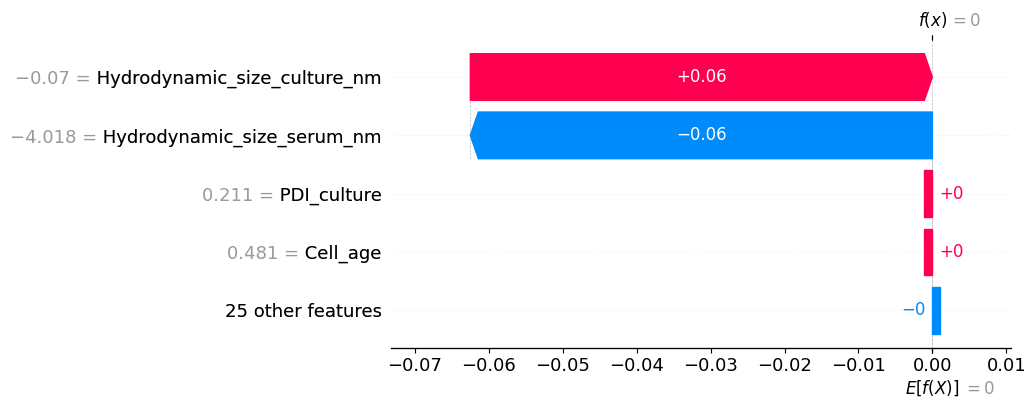

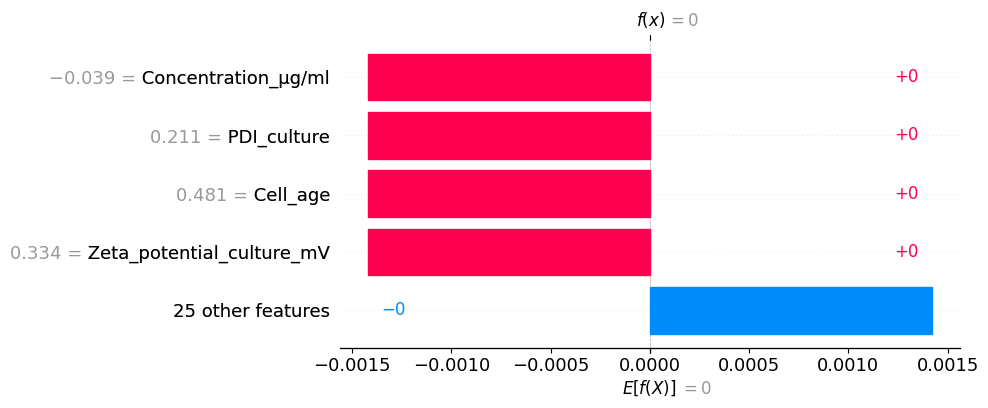

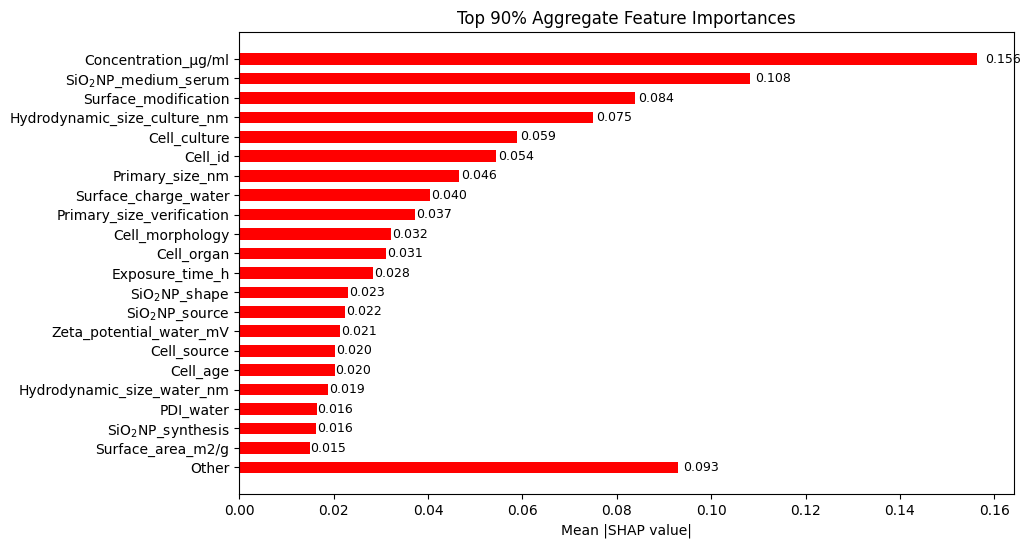

In [29]:
# -----------------------------
# 7. 定义 SHAP Explainer（适配 TabPFN）
# -----------------------------
def get_tabpfn_explainer(estimator, X_test, feature_names, predict_function_for_shap: str | Callable = "predict", **kwargs):
    # 确保输入是 float
    X_float = X_test.astype(float)
    masker = np.ones(X_float.iloc[0:1, :].shape, dtype=float) * np.nan
    predict_fn = getattr(estimator, predict_function_for_shap) if isinstance(predict_function_for_shap, str) else predict_function_for_shap
    return shap.Explainer(predict_fn, masker,feature_names=feature_names, **kwargs)

explainer = get_tabpfn_explainer(clf, X_test_scaled,feature_names=feature_names)

# -----------------------------
# 8. 计算 SHAP 值
# -----------------------------
shap_values = explainer(X_test_scaled.values)
# shap.plots.bar(shap_values=shap_values, show=False)
# plt.title("Aggregate feature importances across the test examples")
# plt.show()

# -----------------------------
# 9. 可视化：Waterfall
# -----------------------------
# 只展示前两个样本示例
for i in range(min(2, len(X_test_scaled))):
    shap.plots.waterfall(shap_values[i], max_display=5)

# # -----------------------------
# # 10. 可视化：Bar plot（平均特征重要性）
# # -----------------------------
# # 全局平均绝对值
# mean_abs_shap = np.abs(shap_values.values).mean(axis=0)
# shap.summary_plot(shap_values, plot_type="bar")




mean_abs_shap = np.abs(shap_values.values).mean(axis=0)

# 放入 DataFrame 并排序
shap_df = pd.DataFrame({
    "feature": feature_names,
    "mean_abs_shap": mean_abs_shap
}).sort_values(by="mean_abs_shap", ascending=False)

# 累计前 90% 重要性
shap_df["cumsum"] = shap_df["mean_abs_shap"].cumsum()
total = shap_df["mean_abs_shap"].sum()
cutoff_idx = np.searchsorted(shap_df["cumsum"]/total, 0.9) + 1

top_features = shap_df.iloc[:cutoff_idx]
other_features = shap_df.iloc[cutoff_idx:]

# 合并剩余特征为 "Other"
if len(other_features) > 0:
    top_features = pd.concat([
        top_features,
        pd.DataFrame({
            "feature": ["Other"],
            "mean_abs_shap": [other_features["mean_abs_shap"].sum()]
        })
    ], ignore_index=True)

# 绘制 Bar plot
plt.figure(figsize=(10, 6))
bars = plt.barh(top_features["feature"], top_features["mean_abs_shap"], color="red", height=0.6)
plt.gca().invert_yaxis()

# 在 bar 上显示数值
for bar in bars:
    width = bar.get_width()
    plt.text(width + 0.01 * width, bar.get_y() + bar.get_height()/2,
             f"{width:.3f}", va="center", fontsize=9)

plt.xlabel("Mean |SHAP value|")
plt.title("Top 90% Aggregate Feature Importances")
plt.show()

In [30]:
top_features["feature"]

0              Concentration_µg/ml
1         SiO$_{2}$NP_medium_serum
2             Surface_modification
3     Hydrodynamic_size_culture_nm
4                     Cell_culture
5                          Cell_id
6                  Primary_size_nm
7             Surface_charge_water
8        Primary_size_verification
9                  Cell_morphology
10                      Cell_organ
11                 Exposure_time_h
12               SiO$_{2}$NP_shape
13              SiO$_{2}$NP_source
14         Zeta_potential_water_mV
15                     Cell_source
16                        Cell_age
17      Hydrodynamic_size_water_nm
18                       PDI_water
19           SiO$_{2}$NP_synthesis
20               Surface_area_m2/g
21                           Other
Name: feature, dtype: object

In [31]:
df = pd.read_csv(r'./Main_Indepedent_Dataset_COLAB.csv', encoding='unicode_escape').drop(columns=['Cell_viability','Publication_id'], axis=1)
df.columns

Index(['Concentration_µg/ml', 'SiO$_{2}$NP_medium_serum', 'Cell_morphology',
       'Cell_organ', 'Primary_size_nm', 'Cell_id', 'Exposure_time_h',
       'Surface_modification', 'Hydrodynamic_size_water_nm', 'Cell_source',
       'Assay_viability', 'Surface_area_m2/g', 'Viability_indicator'],
      dtype='object')

In [32]:
# a = [1, 2, 3, 4]
# b = [3, 4, 5]
a = top_features["feature"].to_list()
b = list(df.columns)
diff_ab = list(set(a) - set(b))  # a 中有但 b 中没有
diff_ba = list(set(b) - set(a))  # b 中有但 a 中没有
print('我们的模型 中有但 论文 中没有',diff_ab,'\n\n')  # [1, 2]



print('论文 中有但 我们的模型中没有',diff_ba)  # [5]


我们的模型 中有但 论文 中没有 ['PDI_water', 'Zeta_potential_water_mV', 'Other', 'Cell_culture', 'SiO$_{2}$NP_shape', 'Primary_size_verification', 'Cell_age', 'SiO$_{2}$NP_source', 'Hydrodynamic_size_culture_nm', 'Surface_charge_water', 'SiO$_{2}$NP_synthesis'] 


论文 中有但 我们的模型中没有 ['Viability_indicator', 'Assay_viability']
